In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_temp = calc_temps('2016-08-01', '2016-08-07')
year_temp

[(72.0, 77.79545454545455, 83.0)]

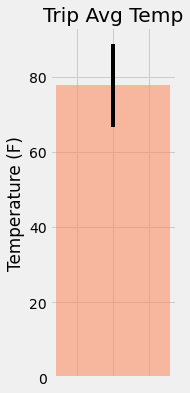

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = (year_temp[0])[1]
yerr = ((year_temp[0])[2])-((year_temp[0])[0])

fig, ax1 = plt.subplots(figsize =(2,6))
ax1.set_title('Trip Avg Temp')
ax1.set_ylabel('Temperature (F)')
ax1.bar(x = 1, height = y, yerr = yerr, color = "coral", alpha = 0.5)
ax1.set_xticklabels([])
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    join(Measurement, Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-08-01').filter(Measurement.date <= '2016-08-07').\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).all()


year_precip = pd.DataFrame(results, columns = ["Station", "Precipitation", "Station Name", "Latitude", "Longitude", "Elevation"])

year_precip


,Station,Precipitation,Station Name,Latitude,Longitude,Elevation
0,USC00519281,3.53,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00513117,2.35,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00516128,2.21,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00519523,0.54,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00519397,0.08,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,USC00514830,NaN,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = ["2017-08-01", "2017-08-02", "2017-08-03", "2017-08-04", "2017-08-05", "2017-08-06", "2017-08-07"]

# Strip off the year and save a list of strings in the format %m-%d
dates = pd.to_datetime(trip_dates).strftime("%m-%d")

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(date) for date in dates]
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame([t for lst in normals for t in lst], columns = ["Minimum Temperature", "Average Temperature", "Maximum Temperature"])

#Add trip_dates
normals_df["Date"]= trip_dates

#Set date as index
normals_df.set_index("Date", inplace=True)

#Display data frame
normals_df


,Minimum Temperature,Average Temperature,Maximum Temperature
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


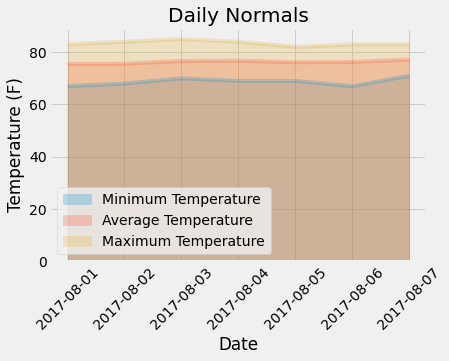

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked = False, alpha=0.25, rot=45)
plt.title("Daily Normals")
plt.ylabel("Temperature (F)")
plt.show()

## Close Session

In [17]:
session.close()